In [1]:
import cv2
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from time import time
%matplotlib notebook

In [2]:
TEMP_PATH = '/home/loitg/workspace/handwriting/temp/'

In [3]:
sample_path = TEMP_PATH + 'ngocnd7_25.jpg'
la_path = TEMP_PATH + 'left_arrow.png'
ra_path = TEMP_PATH + 'right_arrow.png'

In [4]:
la = cv2.imread(la_path, 0)
ra = cv2.imread(ra_path, 0)
sample = cv2.imread(sample_path, 0)

In [27]:
from skimage.filters import threshold_sauvola

def sauvola(grayimg, w=51, k=0.2, scaledown=None, reverse=False):
    mask =None
    if scaledown is not None:
        mask = cv2.resize(grayimg,None,fx=scaledown,fy=scaledown)
        w = int(w * scaledown)
        if w % 2 == 0: w += 1
        mask = threshold_sauvola(mask, w, k)
        mask = cv2.resize(mask,(grayimg.shape[1],grayimg.shape[0]),fx=scaledown,fy=scaledown)
    else:
        if w % 2 == 0: w += 1
        mask = threshold_sauvola(grayimg, w, k)
    if reverse:
        return np.where(grayimg > mask, np.uint8(0), np.uint8(1))
    else:
        return np.where(grayimg > mask, np.uint8(1), np.uint8(0))
    
def estimate_skew_angle(image,angles, binarize=True):
    if binarize:
        binimage = sauvola(image, 11, 0.1).astype(float)
    else:
        binimage = image
    var_max = -np.inf
    angle_max = 0
    rotated_img = None
    for a in angles:
        rotM = cv2.getRotationMatrix2D((binimage.shape[1]/2,binimage.shape[0]/2),a,1)
        rotated = cv2.warpAffine(binimage,rotM,(binimage.shape[1],binimage.shape[0]))
        v = mean(rotated,axis=1)
        d = [abs(v[i] - v[i-1]) for i in range(1,len(v))]
        d = var(d)
        if d > var_max:
            var_max = d
            rotated_img = rotated
            angle_max = a
    return angle_max, rotated_img

(296043840.0, 62484736.0, 201788700.0, (406, 571))


<IPython.core.display.Javascript object>


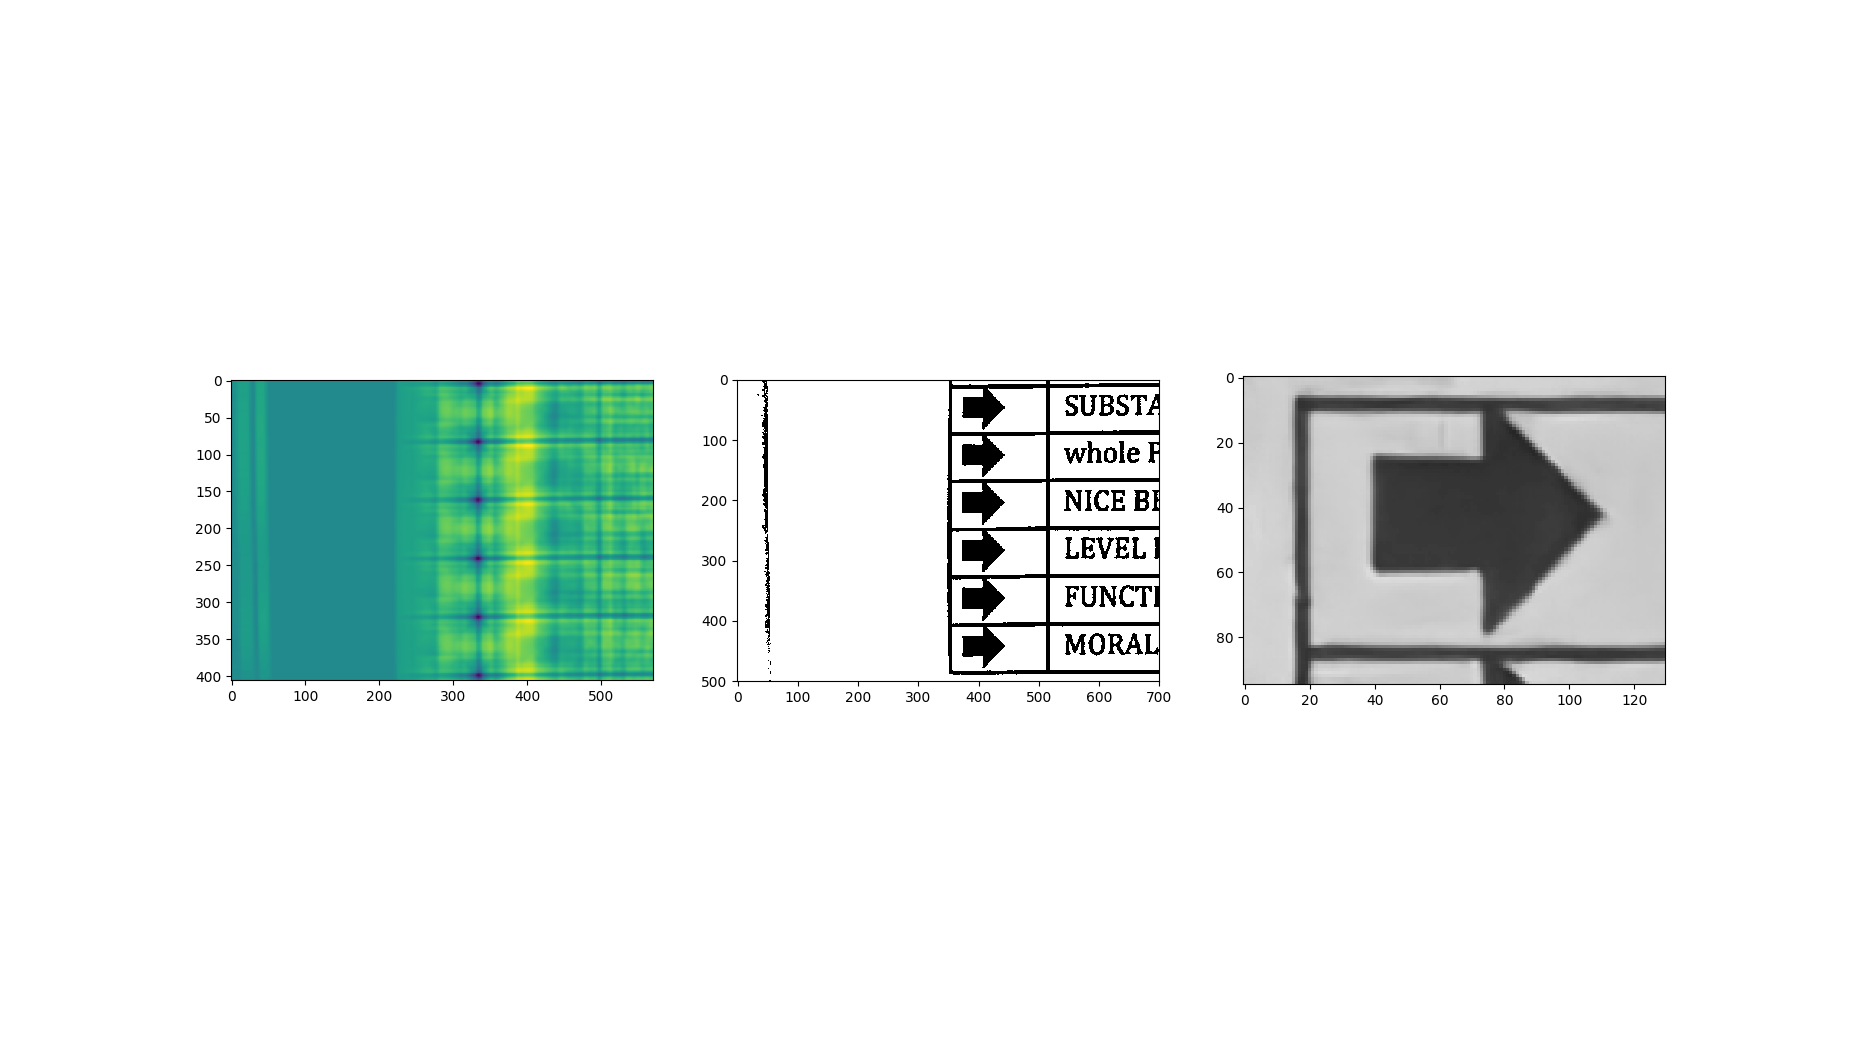

In [6]:
mean_line2height_ratio = 94.0/3024.0
mean_expected_height = sample.shape[0]*mean_line2height_ratio
mean_scale = mean_expected_height/la.shape[0]
binsample = sauvola(sample, k=0.2, w=mean_expected_height/2, scaledown=0.4)*255

testimg = binsample[2500:3000,:700]
scale = 95.0/94
templa = cv2.resize(la, None,fx=scale,fy=scale)
result = cv2.matchTemplate(testimg, templa, method=cv2.TM_SQDIFF)
# h=cv2.normalize(result, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# h=cv2.copyMakeBorder(h, top=0, bottom=templa.shape[0]-1, left=0, right=templa.shape[1]-1, borderType= cv2.BORDER_CONSTANT, value=0 )
print((np.max(result),np.min(result),np.mean(result), result.shape))

fig, axs = plt.subplots(1, 3, sharey=False)
fig.set_size_inches(18.5, 10.5)
axs[0].imshow(result)
axs[1].imshow(testimg, cmap='gray', vmin=0, vmax=255)
axs[2].imshow(templa, cmap='gray', vmin=0, vmax=255)
plt.show()

In [7]:
templa = cv2.resize(la, None,fx=scale,fy=scale)
templa = sauvola(templa, w=mean_expected_height/2, scaledown=0.4)*255

In [8]:
for sc in range(90,100):
    scale = sc*1.0/94
    tempra = cv2.resize(ra, None,fx=scale,fy=scale)
    result = cv2.matchTemplate(testimg, tempra, method=cv2.TM_SQDIFF)
    # h=cv2.normalize(result, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # h=cv2.copyMakeBorder(h, top=0, bottom=templa.shape[0]-1, left=0, right=templa.shape[1]-1, borderType= cv2.BORDER_CONSTANT, value=0 )
    print(sc)
    print((np.max(result),np.min(result),np.mean(result), result.shape))

90
(307942240.0, 138387040.0, 219033280.0, (415, 546))
91
(310709380.0, 144631620.0, 224036600.0, (414, 544))
92
(318757700.0, 142558530.0, 230180820.0, (413, 542))
93
(327299300.0, 133770340.0, 234723870.0, (412, 541))
94
(338828600.0, 126570180.0, 242003220.0, (411, 539))
95
(346138340.0, 122315810.0, 245679400.0, (410, 537))
96
(354567840.0, 117664350.0, 250375420.0, (409, 536))
97
(361576320.0, 117647300.0, 255225920.0, (408, 534))
98
(369696640.0, 116974530.0, 261152720.0, (407, 532))
99
(376794180.0, 119549700.0, 266722860.0, (406, 530))


In [9]:
from ocrolib import psegutils,morph,sl
from skimage.filters import threshold_sauvola, gaussian

def sharpen(binimg):
#     blurred_l= gaussian(binimg,2)
    blurred_l= gaussian(binimg,0.8) #CMND
#     filter_blurred_l = gaussian(blurred_l, 1)
    filter_blurred_l = gaussian(blurred_l, 0.4)  # CMND
    alpha = 30
    return blurred_l + alpha * (blurred_l - filter_blurred_l) 

def findScale(imgpath):
    if imgpath is str:
        img_col = cv2.imread(imgpath)
    else:
        img_col = imgpath
    print(img_col.shape)
    if len(img_col.shape) > 2 and img_col.shape[2]>1:
        img_grey = cv2.cvtColor(img_col, cv2.COLOR_BGR2GRAY)
    else:
        img_grey = img_col
    h,w = img_grey.shape
    img_grey = cv2.normalize(img_grey.astype(np.float32), None, 0.0, 0.99, cv2.NORM_MINMAX)
    img_grey = sharpen(img_grey)
    img_bin_reversed = sauvola(img_grey, w=128, k=0.2, scaledown=0.4, reverse=True)
    
    binary = img_bin_reversed
    binaryary = morph.r_closing(binary.astype(bool), (1,1))
    labels,_ = morph.label(binaryary)
    objects = morph.find_objects(labels) ### <<<==== objects here
    bysize = sorted(range(len(objects)), key=lambda k: sl.area(objects[k]))
    scalemap = np.zeros(binaryary.shape)
    for i in bysize:
        o = objects[i]
        if np.amax(scalemap[o])>0: 
#             mask = where(labels[o] != (i+1),uint8(255),uint8(0))
#             binary[o] = cv2.bitwise_and(binary[o],binary[o],mask=mask)
            continue
        scalemap[o] = sl.area(o)**0.5
    scale = np.median(scalemap[(scalemap>3)&(scalemap<100)]) ### <<<==== scale here
    return img_bin_reversed, scale



In [10]:
findScale(sample)

mean_line2height_ratio = 94.0/3024.0
mean_expected_height = sample.shape[0]*mean_line2height_ratio
mean_scale = mean_expected_height/la.shape[0]
binsample = sauvola(sample, k=0.2, w=mean_expected_height/2, scaledown=0.4)*255

la2box = 94.0/34

box_size = findScale(sample)
est_ratio = box_size/34.0

ratios = est_ratio * np.linspace(0.9,1,1,5)

def findBest(img, template, ratios):
    min_val = +np.inf
    result = None
    for ratio in ratios:
        temp = cv2.resize(template, None,fx=ratio,fy=ratio)
        new_result = cv2.matchTemplate(img, temp, method=cv2.TM_SQDIFF)
        new_val = np.min(result)
        if new_val < min_val:
            min_val = new_val
            result = new_result
    return result, at_ratio

(4032, 3024)


In [53]:
testimg = binsample[:,:].copy()

scale_r = 95.0/94
temp_r = cv2.resize(ra, None,fx=scale_r,fy=scale_r)
result_r = cv2.matchTemplate(testimg, temp_r, method=cv2.TM_SQDIFF)

scale_l = 95.0/94
temp_l = cv2.resize(la, None,fx=scale,fy=scale)
result_l = cv2.matchTemplate(testimg, templa, method=cv2.TM_SQDIFF)

# (90, 162) left (19,9) => (19,84)
# (94, 129) right(144,7) => (144,83)
class Temp(object):
    def __init__(self, root, ratio):
        self.root = root
        self.ratio = ratio
        self.shape = (90,162)
        self.anchor1 = (19,9)
        self.anchor2 = (19,84)
        self.anchorcenter= (19+1148,(9+84)/2)
    def getRect1(self, retType='slice'):
        x1 = self.anchorcenter[0]
        y1 = self.anchor1[1]
        x2 = self.anchor2[0]
        y2 = self.anchor2[1]
        if retType=='slice':
            return [[y1:y2], [x1:x2]]
        elif retType == 'rect':
            return x1,y1,x2-x1,y2-y1
        elif retType == 'points'
    def getAnchorCenter(self):
        return [self.root[0] + self.anchorcenter[0]*self.ratio, self.root[1] + self.anchorcenter[1]*self.ratio]

left_info = Temp(None, 1.0)
left_info.shape = (90,162)
left_info.anchor1 = (19,9)
left_info.anchor2 = (19,84)
left_info.anchorcenter = (19+1148,(9+84)/2)

right_info = Temp(None, 1.0)
right_info.shape = (94, 129)
right_info.anchor1 = (144,7)
right_info.anchor2 = (144,83)
right_info.anchorcenter = (114-1148,(7+83)/2)


# fig, axs = plt.subplots(3,1, sharey=False)
# fig.set_size_inches(8,8)
# axs[0].imshow(result)
# axs[1].imshow(testimg, cmap='gray', vmin=0, vmax=255)
# axs[2].imshow(tempra, cmap='gray', vmin=0, vmax=255)
# plt.show()



In [31]:
la.shape

(94, 129)

<IPython.core.display.Javascript object>


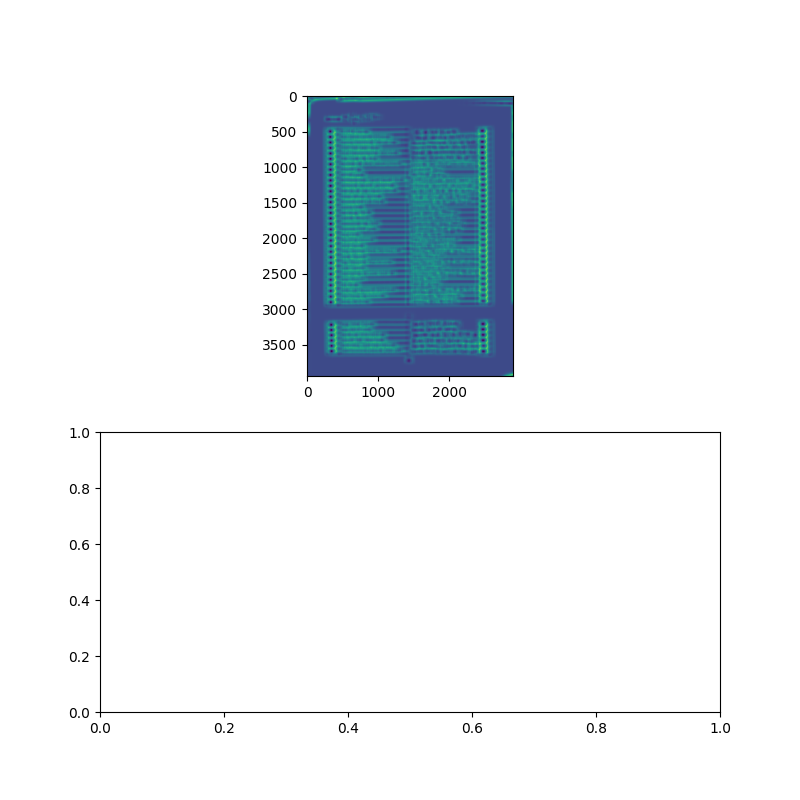

In [32]:
from scipy.ndimage.filters import minimum_filter, gaussian_filter
neighborhood_size = 34/4 #findScale

result = result_l[:,:]
result_blur = gaussian_filter(result, sigma=neighborhood_size)
data_min = minimum_filter(result_blur, neighborhood_size)
minima = np.where(result_blur == data_min)

fig, axs = plt.subplots(2,1, sharey=False)
fig.set_size_inches(8,8)
axs[0].imshow(data_min)



In [22]:
minima = np.where(result_blur == data_min)
values = result[minima]

In [23]:
localMins = zip(values,minima[0], minima[1])
localMins.sort()
localMins

[(25619872.0, 1797, 333),
 (26270080.0, 1416, 331),
 (28415808.0, 1720, 332),
 (28676000.0, 498, 327),
 (30106496.0, 1339, 331),
 (32057312.0, 883, 330),
 (32642560.0, 575, 327),
 (35568576.0, 1110, 330),
 (37194110.0, 1874, 334),
 (39014976.0, 959, 330),
 (39275010.0, 1186, 330),
 (40640576.0, 1034, 330),
 (41680830.0, 1567, 331),
 (42526144.0, 1262, 331),
 (44281920.0, 1491, 331),
 (44282110.0, 2268, 335),
 (45777600.0, 652, 328),
 (47923456.0, 1643, 331),
 (48118560.0, 729, 329),
 (51629824.0, 3438, 345),
 (51954944.0, 806, 329),
 (52215170.0, 2346, 335),
 (53125376.0, 3513, 345),
 (55401280.0, 2504, 334),
 (58587490.0, 2032, 334),
 (59953120.0, 1953, 334),
 (60993470.0, 2111, 334),
 (61123456.0, 2899, 334),
 (63074176.0, 2582, 333),
 (63854496.0, 2740, 333),
 (64699744.0, 2820, 333),
 (66455490.0, 3588, 345),
 (68276290.0, 2661, 333),
 (68536190.0, 2189, 334),
 (70747260.0, 3364, 344),
 (72502750.0, 2425, 334),
 (77249860.0, 3290, 342),
 (80630980.0, 3216, 340),
 (128814460.0, 3358

In [19]:
vis = result[:,:].copy()
topLocalMins_r = localMins[:40]
for val,y,x in topLocalMins_r:
    cv2.circle(vis, (x,y), neighborhood_size, color=127, thickness=3)

<IPython.core.display.Javascript object>


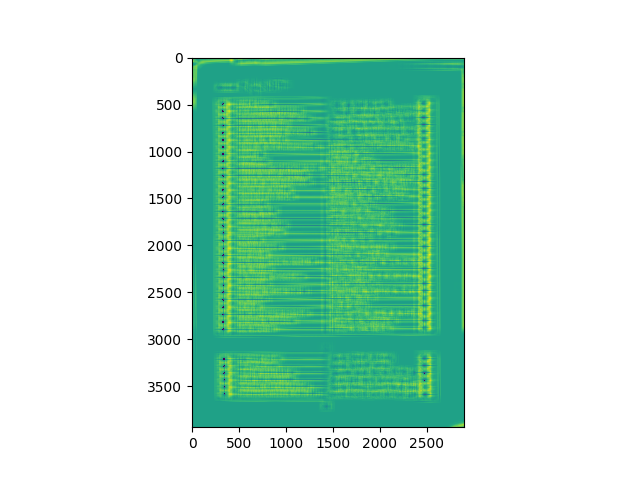

In [25]:
plt.figure()
plt.imshow(vis)

In [24]:
vis = result[:,:].copy()
topLocalMins_l = localMins[:40]
for val,y,x in topLocalMins_l:
    cv2.circle(vis, (x,y), neighborhood_size, color=127, thickness=3)

In [94]:
from sklearn.utils.linear_assignment_ import linear_assignment
import copy

l = []
for val, y, x in topLocalMins_l:
    obj = copy.copy(left_info)
    obj.root = (x,y)
    l.append(obj)
r = []
for val, y, x in topLocalMins_r:
    obj = copy.copy(right_info)
    obj.root = (x,y)
    r.append(obj)

def dist(a, b):
#     print(a)
#     print(b)
    a = np.array(a.getAnchorCenter())
    b = np.array(b.getAnchorCenter())
    ret = np.linalg.norm(a-b)
#     print(ret)
    return np.linalg.norm(a-b)

dist_matrix = np.zeros((len(l),len(r)),dtype=np.float32)
for i,lTemp in enumerate(l):
    for j,rTemp in enumerate(r):
        dist_matrix[i,j] = dist(lTemp,rTemp)
        
matched_indices = linear_assignment(dist_matrix)

In [99]:
for pair in matched_indices[-10:]:
    print(pair)
    print(dist_matrix[pair[0], pair[1]])

[30 35]
38.013157
[31 33]
41.19466
[32 31]
38.483765
[33 30]
38.626415
[34 16]
43.185646
[35 28]
39.0
[36 15]
42.579338
[37 21]
42.201897
[38 39]
4864.114
[39 38]
4668.7734


In [98]:
range(1,3)

[1, 2]